# Electric Vehicle Routing Problem 3 -- Experimente

Website des Wettbewerbs: https://mavrovouniotis.github.io/EVRPcompetition2020/

Problembeschreibung: https://mavrovouniotis.github.io/EVRPcompetition2020/TR-EVRP-Competition.pdf


Wenn Sie den Code in colab ausführen, dann müssen Sie **nichts** weiter tun: Data und Helfercode werden automatisch herunter geladen. Wenn Sie auf Ihrem eigenen Laptop arbeiten, laden Sie Daten und Helfercode unter 
* Daten: https://mavrovouniotis.github.io/EVRPcompetition2020/evrp-benchmark-set.zip
* Helfercode: https://raw.githubusercontent.com/henningbruhn/mobp/main/vrp_aufgabe/evrp.py

herunter, entpacken Sie die Daten und speichern Sie die Daten in einem Verzeichnis namens <code>data</code>. Das Verzeichnis <code>data</code> sowie <code>evrp.py</code> müssen im gleichen Verzeichnis wie dieses Notebook liegen. Kommentieren Sie schließlich die markierten Zeilen in der nächsten Zelle aus.

In [1]:
import random
import math
import matplotlib.pyplot as plt
import numpy as np
import time

path="data"

#### Wenn Sie den Code auf dem eigenen Laptop ausführen, kommentieren Sie die folgenden Zeilen aus ####
# download visualisation and helper code
!wget -q https://raw.githubusercontent.com/henningbruhn/mobp/main/vrp_aufgabe/evrp.py

# download and unpack instance data
!wget -q https://mavrovouniotis.github.io/EVRPcompetition2020/evrp-benchmark-set.zip
!unzip -qo evrp-benchmark-set.zip -d data
#### Ende auskommentieren ####

import evrp

Wir lesen die Instanzen ein und wählen uns eine zum Experimentieren aus.

In [2]:
instances=evrp.read_in_all_instances(path)
inst=instances['E-n33-k4']

Wir picken uns eine der kleinen Instanzen heraus und lassen uns die Instanz anzeigen.

## Genetischer Algorithmus

In [3]:
### global parameters that govern genetic algorithm
### this is a bit of a hack---better would be to encapsulate 
### the genetic algorithm in a proper class
### however, this makes for simpler code
SELECTION_SIZE=3
RESET_RATE=0.25
MUTATE_NUM=3
MUTATION_RATE=0.25
INSERT_TRIES=10

def genetic_algo(instance,population_size,time_budget,record=False):
    """
    main routine for genetic algorithm
    instance: the EVRP instance
    population_size: how many solutions in a generation?
    time_budget: run for how much time? (in s)
    record: whether to keep track of all populations over the generations (for analytics)
    """
    start=time.time()
    population=compute_initial_population(instance,population_size)
    best=math.inf
    best_animal=None
    pop_over_generations=[]
    generation=0
    while time.time()-start<time_budget:
        generation+=1
        scores=compute_scores(population,instance)
        if record:
            pop_over_generations.append(population)
        best,best_animal=update_best(best,best_animal,scores,population)
        child_population=[]
        for i in range(population_size):
            parent1=select(population,scores)
            parent2=select(population,scores)
            child=crossover(parent1,parent2,instance)
            child=mutate(child,instance)            
            child_population.append(child)
        population=child_population
    if record:
        print("time elapsed: {}s".format(round(time.time()-start)))
        print("number of generations: {}".format(len(pop_over_generations)))
        return best_animal,pop_over_generations
    return best_animal

def select(population,scores):
    """pick best out of SELECTION_SIZE many random animals"""
    global SELECTION_SIZE
    N=len(population)
    choice=random.sample(range(N),SELECTION_SIZE)
    best=math.inf
    best_index=None
    for index in choice:
        if scores[index]<best:
            best=scores[index]
            best_index=index
    return population[best_index]

def strip_stations(tour,instance):
    """
    remove all charging stations from all tours
    """
    new_tour=[]
    for vehicle_tour in tour:
        new_vehicle_tour=[stop for stop in vehicle_tour if stop in instance.customers and stop!=instance.depot]
        new_tour.append(new_vehicle_tour)
    return new_tour

def reset_stations(tour,instance):
    """
    remove all charging stations from the tours, and then runs a heuristic that tries to insert charging stations 
    with cost as small as possible (basically a greedy insertion heuristic)
    """
    new_tour=strip_stations(tour,instance)
    evrp.fix_range(new_tour,instance)
    return new_tour

def move_mutation(tour):
    ### randomly move some stop to some other car / position
    vehicle_tour1=random.choice(tour)
    if len(vehicle_tour1)==0:
        return
    vehicle_tour2=random.choice(tour)
    pos1=random.randint(0,len(vehicle_tour1)-1) ## depot at start? no
    stop=vehicle_tour1.pop(pos1)
    pos2=random.randint(0,len(vehicle_tour2))
    vehicle_tour2.insert(pos2,stop)
    
def mutate(tour,instance):
    """
    currently two possible mutations: reset all charging stations, and move customer from one tour to some other tour
    global parameters:
    RESET_RATE: probability to reset all charging stations
    MUTATE_NUM: number of times, a move mutation may be possible
    MUTATION_RATE: probability that a move mutation occurs
    """
    global RESET_RATE,MUTATE_NUM,MUTATION_RATE
    mutation=tour
    if random.random()<=RESET_RATE:
        mutation=reset_stations(tour,instance)
    for _ in range(MUTATE_NUM):
        if random.random()<=MUTATION_RATE:
            move_mutation(mutation)
    return mutation

def find_missing_and_doubles(child,instance):
    doubles=[]
    counted=[instance.depot]
    for vehicle_tour in child:
        for stop in vehicle_tour:
            if stop in instance.customers:
                if stop in counted and stop!=instance.depot:
                    doubles.append(stop)
                else:
                    counted.append(stop)
    missing=[customer for customer in instance.customers if not customer in counted]
    return missing,doubles

def best_insert_single_missing(tour,missing,instance):
    """
    greedy insertion heuristic for missing customers 
    """
    best=math.inf
    best_pos=None
    for _ in range(INSERT_TRIES):
        vehicle_tour=random.choice(tour)
        pos=random.randint(0,len(vehicle_tour))
        vehicle_tour.insert(pos,missing)
        score=evrp.soft_objective_function([vehicle_tour],instance)
        if score<best:
            best=score
            best_pos=(vehicle_tour,pos)
        del vehicle_tour[pos]
    vehicle_tour,pos=best_pos
    vehicle_tour.insert(pos,missing)

def best_insert_all_missing(tour,missings,instance):
    random.shuffle(missings)
    for m in missings:
        best_insert_single_missing(tour,m,instance)
        
def strip_doubles(child,exchanged_car,doubles):
    for i,vehicle_tour in enumerate(child):
        if i==exchanged_car:
            continue
        stripped=[stop for stop in vehicle_tour if not stop in doubles]
        child[i]=stripped
    
def fix(child,exchanged_car,instance):
    missings,doubles=find_missing_and_doubles(child,instance)
    strip_doubles(child,exchanged_car,doubles)
    best_insert_all_missing(child,missings,instance)
    
def crossover(parent1,parent2,instance):
    """
    pick random tour of parent1, pick random tour of parent2 and replace 
    first tour by second tour
    then fix solution, ie, remove customers that appear twice and insert customers that have been lost
    (lost customers are greedily inserted)
    """
    ### exchange single vehicle
    first_car=random.randint(0,len(parent1)-1)
    second_car=random.randint(0,len(parent2)-1)
    child=deepcopy(parent1)  ## need to do deep copy
    child[first_car]=parent2[second_car].copy()
    fix(child,first_car,instance)
    return child

def compute_initial_population(instance,N):
    """
    generate tours in random order, then run heuristic to insert charging stations as needed
    """
    population=[]
    for _ in range(N):
        tour=evrp.rnd_tour(instance)
        evrp.fix_range(tour,instance)
        population.append(tour)
    return population
        
def compute_scores(population,instance):
    """
    compute objective function for every solution
    """
    scores=[]
    for tour in population:
        score=evrp.soft_objective_function(tour,instance)
        scores.append(score)
    return scores

def update_best(best,best_animal,scores,population):
    """
    keep track of best solution seen so far
    returns current best solution
    """
    for score,animal in zip(scores,population):
        if score<best:
            best=score
            best_animal=animal
    return best,best_animal

def deepcopy(tour):
    return [vehicle_tour.copy() for vehicle_tour in tour]

TIME_BUDGET=60

## Experimente

Wie gut der genetische Algorithmus funktioniert, hängt von der Einstellung der Parameter ab, also der Wahl der Populationsgröße <code>POP_SIZE</code>, wie selektiv die Eltern ausgewählt werden <code>SELECTION_SIZE</code> und den Mutationsraten <code>MUTATE_NUM</code>, <code>MUTATION_RATE</code> und <code>RESET_RATE</code>. Das Zeitbudget <code>TIME_BUDGET</code> wollen wir fix lassen (und auch <code>INSERT_TRIES</code> lassen wir so wie's ist).

Lassen wir den Algorithmus einmal laufen.

In [4]:
SELECTION_SIZE=30
RESET_RATE=0.25
MUTATE_NUM=3
MUTATION_RATE=0.25
INSERT_TRIES=10
POP_SIZE=100

gen_tour,pops=genetic_algo(inst,POP_SIZE,TIME_BUDGET,record=True)

time elapsed: 60s
number of generations: 241


Wir können uns Statistiken über die Tour anzeigen lassen...

In [5]:
evrp.vehicle_stats(gen_tour,inst)

,Auslastung,Ladungs-Min,#Ladehalts,Streckenlänge
Fahrzeug,,,,
1,7400.0,18.9,1.0,259.7
2,7200.0,70.8,1.0,184.1
3,7000.0,34.2,1.0,252.0
4,7770.0,49.3,1.0,252.4


...oder diese gleich visualisieren lassen.

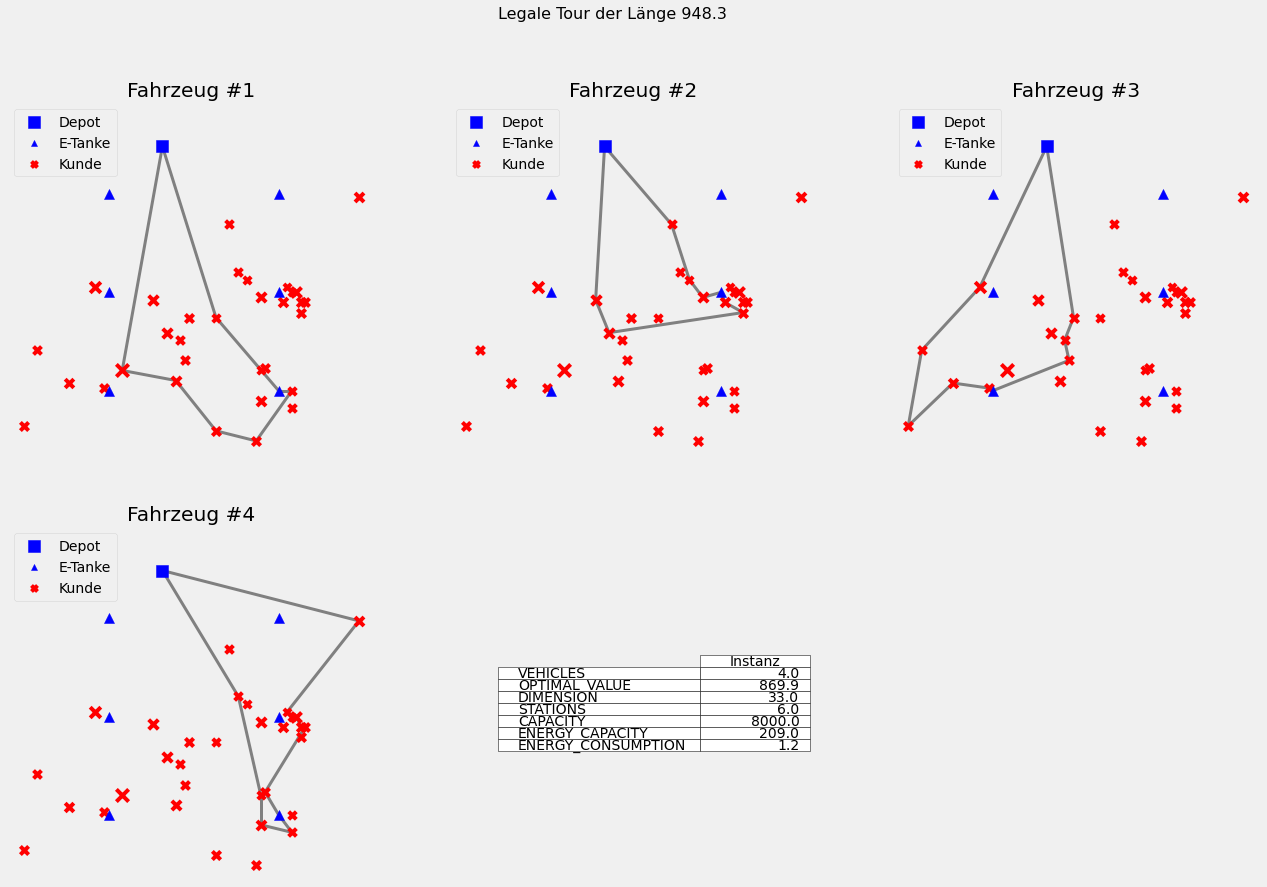

In [6]:
evrp.show(inst,tour=gen_tour)

Insbersondere aber können wir uns den Verlauf des Algorithmus über die Generationen anzeigen lassen.

Erklärungsbedürftig sollte hier nur die *Diversität* sein. Hier wird ermittelt wie groß der Anteil gemeinsamer Kanten von Paaren von Lösungen in der Population ist. Ist der Anteil groß, so ist die Diversität nahe 0, ist der Anteil klein, so ist die Diversität nahe 1.

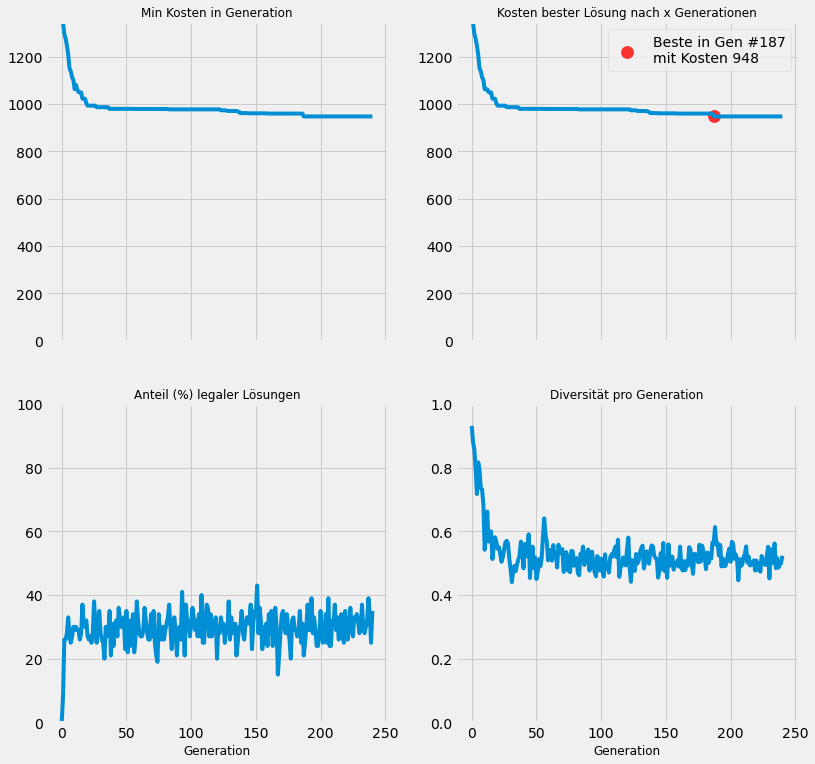

In [7]:
evrp.show_analytics(pops,inst)

## Aufgaben

* Experimentieren Sie mit den Parametern! Wie wirkt sich eine veränderte Populationsgröße aus? Was passiert, wenn die Mutationsrate sehr hoch oder sehr niedrig gesetzt wird? 